In [1]:
import chromadb
from IPython.lib.deepreload import original_import
from asttokens.util import token_repr
from nltk import grow_diag_final_and
from pymupdf.mupdf import pdf_read_journal

from RAG.helper_utils import project_embeddings
from helper_utils import word_wrap
from pypdf import PdfReader
import os
from groq import Groq
from dotenv import load_dotenv

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")

reader = PdfReader("artificial_intelligence.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

pdf_texts = [text for text in pdf_texts if text]
# print(
#     word_wrap(
#         pdf_texts[0],
#         width=100
#     )
# )




Split the text into smaller chunks 

In [2]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)


character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n","\n",". "," ", ""],chunk_size=1000,chunk_overlap=0
)

character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))



token_splitters = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitters.split_text(text)

# print(word_wrap(character_split_texts[10]))
# print(f"\n Total chunks: {len(character_split_texts)} ")

In [3]:
import umap
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
# print(embedding_function([token_split_texts[10]]))

chroma_client = chromadb.Client()
chroma_collection = chroma_client.get_or_create_collection(
    "ai-collection", embedding_function=embedding_function
)

# extract the embeddings from the token_split_texts
ids = [str(i) for i in range(len((token_split_texts)))]
chroma_collection.add(ids=ids, documents=token_split_texts)
count = chroma_collection.count()
# print(count)

query = "What is the meaning of Artificial Intelligence"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]
# print documents in chunks
# for document in retrieved_documents:
#     print(word_wrap(document))
#     print("\n")
#
client = Groq(api_key=groq_api_key)

def augmented_query_generation(query, model="llama-3.3-70b-versatile"):
    prompt = """You are a helpful expert research assistant.I am providing an example answer to the given question, that might be found in document like artificial intelligence """
    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

original_query = "Will artificial intelligence replace the humans"
hypothetical_answer = augmented_query_generation(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"][0]

embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

# FIXED LINE:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

retrieved_embeddings = results["embeddings"][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(
    original_query_embedding, umap_transform
)

projected_augmented_query_embedding = project_embeddings(
    augmented_query_embedding, umap_transform
)


Will artificial intelligence replace the humans **The Impact of Artificial Intelligence
 on Human Employment**

Artificial intelligence (AI) has been increasingly integrated i
nto various industries, revolutionizing the way tasks are performed and automating many
 processes. While AI has the potential to augment human capabilities and improve produc
tivity, concerns have been raised about its potential to replace human workers.

**Argu
ments For and Against AI Replacement of Humans**

**Arguments For Replacement:**

1. **
Automation of Routine Tasks**: AI can perform repetitive, mundane, and time-consuming t
asks more efficiently and accurately than humans, potentially replacing certain jobs.
2
. **Increased Efficiency**: AI can process vast amounts of data, analyze patterns, and 
make predictions, potentially leading to increased productivity and reduced labor needs
.
3. **Cost Savings**: Implementing AI systems can reduce labor costs, as machines do n
ot require salaries, benefits, o

C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' i

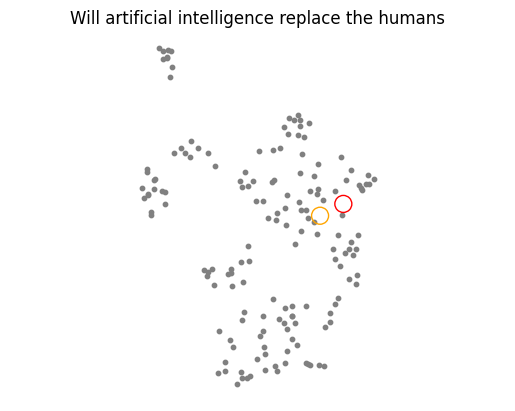

In [4]:
import matplotlib.pyplot as plt

plt.figure()

plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)

plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    facecolors="none",
    edgecolors="r",
)

plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    facecolors="none",
    edgecolors="orange",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()
